# Try again to calculate J and U. This time use functional Hamiltonian since that is used for diagonalisation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from IPython.display import Math, display
from scipy import constants as const
from scipy import sparse
from scipy.fft import fftn, ifftn, fftfreq
from scipy.optimize import root_scalar
import pickle

#add relative path to backend
import sys
sys.path.append('../../clean_diag/backend')

import trap_units as si
from trap_numerics import functional_hamiltonian

In [2]:
line_number = 7 # line of file in overview.txt

with open("data/overview.txt", "r") as file:
    for current_line_number, line in enumerate(file, start=1):
        if current_line_number == line_number:
            timecode = line[:19]  # Get the first 19 characters
            break  # Stop reading once we get the desired line

data = np.load(f"data/{timecode}_results.npz",allow_pickle=True)
for key in data.keys():
    globals()[key] = data[key]

with open(f"data/{timecode}_trap.npz", 'rb') as file:
    trap = pickle.load(file)

ham = sparse.load_npz(f"data/{timecode}_hamiltonian.npz")
func_ham = functional_hamiltonian(dvol,pot,float(trap.subs(trap.m)))

In [3]:
omega_z1 = sp.sqrt(4*trap.power_tweezer1*trap.a/sp.pi**3/trap.m) * trap.wvl/trap.waist_tweezer1**3
omega_z2 = sp.sqrt(4*trap.power_tweezer2*trap.a/sp.pi**3/trap.m) * trap.wvl/trap.waist_tweezer2**3

omega_r1 = sp.sqrt(2*trap.power_tweezer1*trap.a/sp.pi/trap.m) * 2/trap.waist_tweezer1**2
omega_r2 = sp.sqrt(2*trap.power_tweezer2*trap.a/sp.pi/trap.m) * 2/trap.waist_tweezer2**2

print(f"omega_r1: {float(trap.subs(omega_r1)):.1f}Hz, omega_r2: {float(trap.subs(omega_r2)):.1f}Hz")
print(f"omega_z1: {float(trap.subs(omega_z1)):.1f}Hz, omega_z2: {float(trap.subs(omega_z2)):.1f}Hz")

aspect_ratio1 = omega_r1 / omega_z1
_aspect_ratio1_latex = sp.latex(trap.omega_r_tweezer / trap.omega_ax_tweezer)
display(Math(f"{_aspect_ratio1_latex} \\approx {trap.subs(aspect_ratio1).evalf():.2f}"))

aspect_ratio2 = omega_r2 / omega_z2
_aspect_ratio2_latex = sp.latex(trap.omega_r_tweezer / trap.omega_ax_tweezer)
display(Math(f"{_aspect_ratio2_latex} \\approx {trap.subs(aspect_ratio2).evalf():.2f}"))

omega_r1: 7331.9Hz, omega_r2: 7331.9Hz
omega_z1: 418.1Hz, omega_z2: 418.1Hz


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Turn state vector into real space wavefunction by adjusting normalisation:

In [4]:
np.sum(np.abs(states[0]**2))

0.9999999999999993

In [5]:
dV = np.prod(dvol)

states_r = states/ np.sqrt(dV)

In [6]:
np.sum(np.abs(states_r[0]**2))*dV

0.9999999999999993

Check how diagonalisation looks:

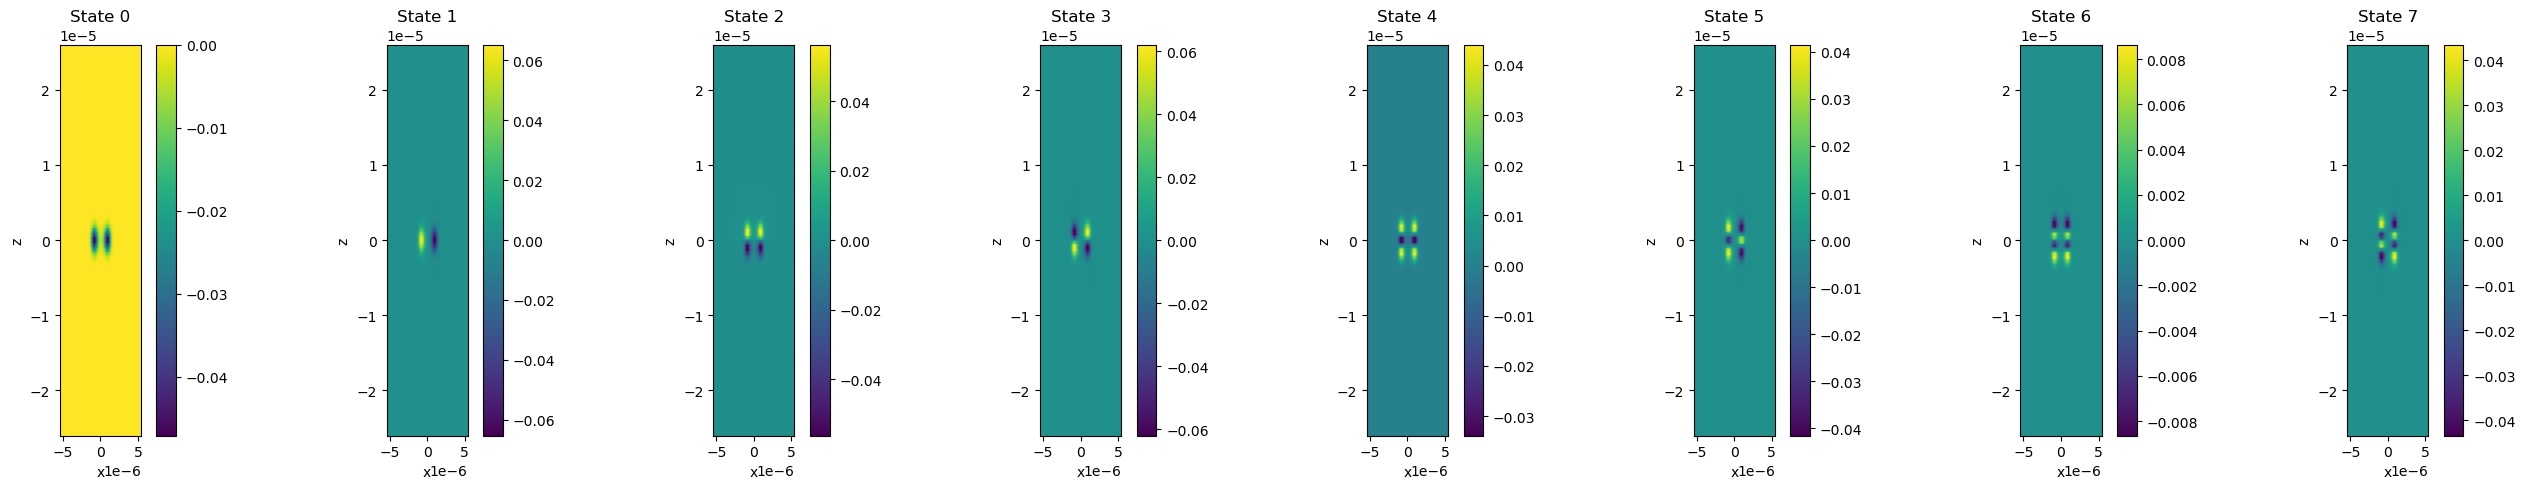

In [7]:
n_states = 8

states_plot = states.real
#states_plot = np.angle(states)
#states_plot = states.imag
#states_plot = np.abs(states)**2

# Create a 1xn_states grid of subplots (1 row, n_states columns)
fig, axes = plt.subplots(1, n_states, figsize=(20/6*n_states, 5))  # Adjust the size as needed

# Loop over the state numbers from 0 to n_states-1
for state_number, ax in zip(range(n_states), axes):
    # Slice through the y-direction and rotate the x-z plane (by swapping x and z)
    im = ax.imshow(states_plot[state_number, :, int(len(y)/2), :].T,
                   extent=[*extend[0], *extend[2]], origin="lower",
                   vmin=np.min(states_plot[state_number]), vmax=np.max(states_plot[state_number]))

    # Set labels for each subplot
    ax.set_xlabel("x")
    ax.set_ylabel("z")
    ax.set_title(f"State {state_number}")
    fig.colorbar(im, ax=ax)  

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


Find localised wave functions:

In [8]:
#rotate resulting wavefunctions into symmetric and anti-symm. states 
def f(alpha):

    state_S1 = np.cos(alpha) * states[0].real + np.sin(alpha)* states[1].real
    state_S1 /= np.sqrt(np.sum(np.abs(state_S1)**2))

    state_A1 = np.sin(alpha) * states[0].real - np.cos(alpha)* states[1].real
    state_A1 /= np.sqrt(np.sum(np.abs(state_A1)**2))

    return np.sum(state_S1[int(len(x)/2):]) - np.sum(state_S1[:int(len(x)/2)])

#find optimal angle
# alpha = minimize_scalar(f,bounds=(-2*np.pi, 2*np.pi+0.1)).x
alpha = root_scalar(f, x0=0).root

state_S1 = np.cos(alpha) * states[0].real + np.sin(alpha)* states[1].real
state_S1 /= np.sqrt(np.sum(np.abs(state_S1)**2))

state_A1 = np.sin(alpha) * states[0].real - np.cos(alpha)* states[1].real
state_A1 /= np.sqrt(np.sum(np.abs(state_A1)**2))

#then transform to localised wavefunctions
GS_LR1 = (state_S1 + state_A1)/np.sqrt(2)
GS_LR2 = (state_S1 - state_A1)/np.sqrt(2)

#asign left and right
if abs(np.sum(GS_LR1[int(len(x)/2):])) < abs(np.sum(GS_LR1[:int(len(x)/2)])):
    GS_left = GS_LR1
    GS_right = GS_LR2
else:
    GS_left = GS_LR2
    GS_right = GS_LR1

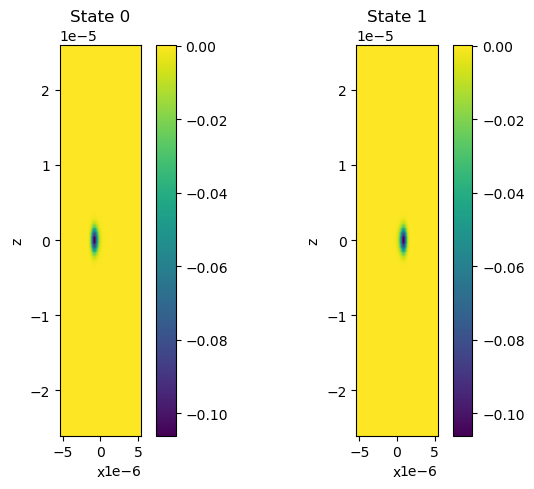

In [9]:
n_states = 2

states_plot = [GS_left.real, GS_right.real]
#states_plot = np.angle(states)
#states_plot = states.imag
#states_plot = np.abs(states)**2

# Create a 1xn_states grid of subplots (1 row, n_states columns)
fig, axes = plt.subplots(1, n_states, figsize=(20/6*n_states, 5))  # Adjust the size as needed

# Loop over the state numbers from 0 to n_states-1
for state_number, ax in zip(range(n_states), axes):
    # Slice through the y-direction and rotate the x-z plane (by swapping x and z)
    im = ax.imshow(states_plot[state_number][:, int(len(y)/2), :].T,
                   extent=[*extend[0], *extend[2]], origin="lower",
                   vmin=np.min(states_plot[state_number]), vmax=np.max(states_plot[state_number]))

    # Set labels for each subplot
    ax.set_xlabel("x")
    ax.set_ylabel("z")
    ax.set_title(f"State {state_number}")
    fig.colorbar(im, ax=ax)  

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


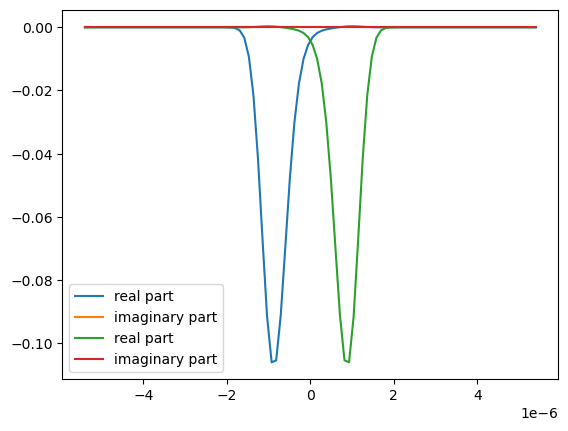

In [10]:
state_number = 0
phase_mult0 = 1

plt.plot(x,(phase_mult0*GS_left[:,int(len(y)/2),int(len(z)/2)]).real, label="real part")
plt.plot(x,(phase_mult0*GS_left[:,int(len(y)/2),int(len(z)/2)]).imag, label="imaginary part")
#plt.plot(x,pot[:,int(len(y)/2),int(len(z)/2)], label="potential (rescaled)")
plt.legend()

state_number = 1
phase_mult1 = 1

plt.plot(x,(phase_mult1*GS_right[:,int(len(y)/2),int(len(z)/2)]).real, label="real part")
plt.plot(x,(phase_mult1*GS_right[:,int(len(y)/2),int(len(z)/2)]).imag, label="imaginary part")
#plt.plot(x,pot[:,int(len(y)/2),int(len(z)/2)], label="potential (rescaled)")
plt.legend()
plt.show()

## Calculate parameters:

### Start with contact interactions:

In [11]:
#make sure we're working with state vector
np.sum(np.abs(GS_left)**2)

0.9999999993379817

In [12]:
#scattering length
a_s = 85* const.physical_constants["Bohr radius"][0]

#calculate integral over psi^4 (divide by sqrt(dV) to convert to wavefunction)
U_s = np.sum(np.abs(GS_left/np.sqrt(dV))**4)*dV
U_s *= 4*np.pi*const.hbar**2*a_s/float(trap.subs(trap.m))

print(f"U_s = {U_s/const.h} Hz")

U_s = 3.2123021180831275 Hz


### Then do single-particle hopping:

In [13]:
#make sure we're working with state vector
np.sum(np.abs(GS_left)**2)

0.9999999993379817

In [14]:
#call Hamiltonian on one side
H_psi = np.reshape(func_ham(np.reshape(GS_right, -1)), size)

#calculate integral
J = -(np.sum(GS_left.conj()/np.sqrt(dV)* H_psi/np.sqrt(dV))*dV)

#check imaginary part of result (should vanish)
if abs(J.real/J.imag) < 10:
    raise Exception(f"imaginary part of J too big: J = {J}")
else:
    J = J.real

print(f"J = {J/const.h} Hz")

J = 0.9876660072698075 Hz


### Finally dipole interactions:

In [15]:
angles= np.deg2rad(np.linspace(0,90))
U_dds = np.zeros_like(angles, dtype=complex)

for i, theta in enumerate(angles):
    #compute dipolar interactions using fourier transform

    #direction of polarisation (B-field) [x,y,z]
    #theta = np.deg2rad(0)
    pol =np.array([np.sin(theta),0,np.cos(theta)])

    #density
    rho = np.abs(GS_left/np.sqrt(dV))**2
    # Compute Fourier transform of density
    rho_k = fftn(rho)

    #set up fourier space
    kx = 2*np.pi*fftfreq(size[0], dvol[0])
    ky = 2*np.pi*fftfreq(size[1], dvol[1])
    kz = 2*np.pi*fftfreq(size[2], dvol[2])
    KX, KY, KZ = np.meshgrid(kx, ky, kz, indexing='ij')
    K2 = KX**2 + KY**2 + KZ**2
    K2[K2 == 0] = np.inf  # Avoid division by zero

    # Compute dipolar interaction kernel in Fourier space
    V_k = (-1 + 3* (pol[0]*KX + pol[1]*KY + pol[2]*KZ)**2 / K2) /3

    # Compute convolution in Fourier space
    U_dd_k = V_k * rho_k

    # Transform back to real space
    U_dd_real = ifftn(U_dd_k)

    # Integrate
    U_dd = (np.sum(U_dd_real*rho) * dV) 
    #multiply by prefactor C_dd
    U_dd *= const.mu_0*float(trap.subs(trap.mu_b))**2

    #check imaginary part of result (should vanish)
    if abs(U_dd.real/U_dd.imag) < 10:
        raise Exception(f"imaginary part of U_dd too big: U_dd = {U_dd}")
    else:
        U_dd = U_dd.real

    U_dds[i] = U_dd
    #print(f"U_dd = {U_dd/const.h} Hz")

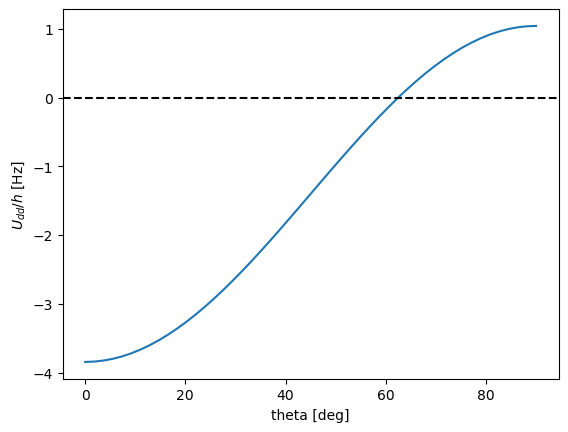

In [16]:
plt.plot(np.rad2deg(angles), U_dds.real/const.h)
#plt.plot(angles, U_dds.imag/const.h)

plt.axhline(0,color="black",ls="--")

plt.xlabel("theta [deg]")
plt.ylabel(r"$U_{dd} / h$ [Hz]")
plt.show()

---------